In [62]:
!pip install tensorflow matplotlib opencv-python pydot graphviz seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 262.6 kB/s eta 0:00:02
   ----- --------------------------------- 41.0/294.9 kB 245.8 kB/s eta 0:00:02
   ---------- ---------------------------- 81.9/294.9 kB 456.6 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/294.9 kB 655.8 kB/s eta 0:00:01
   ------------------------------- ------ 245.8/294.9 kB 942.1 kB/s eta 0:00:01
   ------------------------------------ - 286.7/294.9 kB 980.4 kB/s eta 0:00:01
   -------------------------------------- 294.9/294.9 kB 958.5 kB/s eta 0:00:00


In [9]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Dense, \
    Concatenate, Add, ReLU, BatchNormalization, AvgPool2D, MaxPool2D, GlobalAvgPool2D, \
    Reshape, Permute, Lambda
import tensorflow as tf

In [3]:
def stage(x, channels, repetitions, groups):
    x = shufflenet_block(x, channels, 2, groups) #strides=2 içim
    for _ in range(repetitions):
        x = shufflenet_block(x, channels, 1, groups) #strides=1 için
    return x

In [4]:
def shufflenet_block(tensor, channels, strides, groups):
    x = gconv(tensor, channels // 4, groups)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)
    x = DepthwiseConv2D(3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)

    if strides == 2:
        channels = channels - tensor.shape[-1]

    x = gconv(x, channels, groups)
    x = BatchNormalization()(x)

    if strides == 1:
        x = Add()([tensor, x])
    else:
        avg = AvgPool2D(3, strides=2, padding='same')(tensor)
        x = Concatenate()([avg, x])
    x = ReLU()(x)
    return x

In [5]:
def gconv(tensor, channels, groups):
    input_shape = tf.keras.backend.int_shape(tensor)
    input_ch = input_shape[-1]
    group_ch = input_ch // groups
    output_ch = channels // groups
    groups_list = []

    for i in range(groups):
        #group_tensor = tensor[:, :, :, (i*group_ch): (i+1) * group_ch]
        group_tensor = Lambda(lambda x: x[:, :, :, (i*group_ch): (i+1) * group_ch], output_shape=(input_shape[1], input_shape[2], group_ch))(tensor) #lambda normalinden daha hızlı çalıştığı için hız istnen durumlarda daha çok tercih ediliyor
        group_tensor = Conv2D(output_ch, 1)(group_tensor)
        groups_list.append(group_tensor)
    output = Concatenate()(groups_list)
    return output

In [6]:
def channel_shuffle(x, groups):
    _, width, height, channels = x.shape
    group_ch = channels // groups
    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [7]:
#MODELİ OLUŞTURMAYA BAŞLAYABİLİRİZ

input = Input(shape=(224, 224, 3))  #girdi olarak verilecek veri setinin sahip olması gereken boyutları ve channel sayısını belirtiyor. shufflenet girdi olarak bunu kabul ediyor.
x = Conv2D(24, 3 ,strides=2, padding='same')(input) #24 filters, 3×3 kernel size, strides 2
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D(3, strides=2, padding='same')(x) #3×3 kernel size, strides 2

In [10]:
repetitions = 3, 7, 3 #stage2, stage3, stage4 #stage içerisinde her stage için zorunlu ilk adım olan strides 2'yi yaptırdığım için tekrar sayılarını normalden birer eksik verebiliyorum.
initial_channels = 128
groups = 3

for i, reps in enumerate(repetitions):
    channels = initial_channels * (2**i)
    x = stage(x, channels, reps, groups)

In [11]:
#print("Shape before GlobalAvgPool2D:", x.shape)
x = GlobalAvgPool2D()(x)
#print("Shape after GlobalAvgPool2D:", x.shape)
output = Dense(2, activation='softmax')(x)

from tensorflow.keras import Model
model = Model(input, output)

In [12]:
#MODELİ EĞİTMEK İÇİN VERİ SETLERİNİ ALIP MODELİN İSTEDİĞİ HALE GETİRMEM LAZIM Kİ DOĞRU ÇALIŞABİLSİN --> PREPROCESSING
#Bundan sonraki adımlarda bana gerekecek olan kütüphaneleri ekliyorum

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow as tf
from matplotlib import pyplot as plt

In [13]:
#test verisetimde resimler kategorilerine göre klasörlere ayrılmadığından train klasörümdeki verilerin 0.1i kadarını ayrı bir klasöre bölüyorum
#BUNU SADECE VE SADECE BİR KERE ÇALIŞTIRMIŞ VE KLASÖRLERİ AYIRMIŞSAN SAKIN BİR DAHA ÇALIŞTIRMA VERİLERİ TEKRAR TEKRAR KOPYALAYIP DOSYAYI ŞİŞİRİYORSUN ÇÜNKÜ!!! GEREKSİZ VERİ TEKRARI = OVERFITING

import os
import shutil
import random

def split_dataset(source_dir, train_dir, validation_dir, test_dir, train_split=0.7, validation_split=0.2):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            random.shuffle(images)
            train_split_point = int(len(images) * train_split)
            validation_split_point = int(len(images) * (train_split + validation_split))

            train_images = images[:train_split_point]
            validation_images = images[train_split_point:validation_split_point]
            test_images = images[validation_split_point:]

            os.makedirs(os.path.join(train_dir, category), exist_ok=True)
            os.makedirs(os.path.join(validation_dir, category), exist_ok=True)
            os.makedirs(os.path.join(test_dir, category), exist_ok=True)

            for image in train_images:
                shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category, image))

            for image in validation_images:
                shutil.copy(os.path.join(category_path, image), os.path.join(validation_dir, category, image))

            for image in test_images:
                shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, category, image))

source_dir = 'datasets/realfakedataset_HARD'
train_dir = 'datasets/realfakedataset_HARD/train'
validation_dir = 'datasets/realfakedataset_HARD/validation'
test_dir = 'datasets/realfakedataset_HARD/test'

split_dataset(source_dir, train_dir, validation_dir, test_dir)

PermissionError: [Errno 13] Permission denied: 'datasets/realfakedataset_HARD\\test\\real'

In [14]:
train_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2])   

train_datas = train_generate.flow_from_directory(
    'datasets/realfakedataset_HARD/train', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 901 images belonging to 2 classes.


In [15]:
validation_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

validation_datas = validation_generate.flow_from_directory(
    'datasets/realfakedataset_HARD/validation', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 258 images belonging to 2 classes.


In [16]:
test_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datas = test_generate.flow_from_directory(
    'datasets/realfakedataset_HARD/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Type of class labels
    shuffle=False)

Found 130 images belonging to 2 classes.


In [2]:
from tensorflow.keras.optimizers import Adam

In [3]:
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

logdir = 'shufflenet_logs_harddataset' #eğitimle ilgili logların tutulacağı bir klasör oluşturuyoruz
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

NameError: name 'model' is not defined

In [19]:
hist = model.fit(train_datas, epochs=21, validation_data=validation_datas, callbacks=[tensorboard_callback])

Epoch 1/21


C:\Users\ilayd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5507 - loss: 0.7073 - val_accuracy: 0.5426 - val_loss: 0.6917
Epoch 2/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6587 - loss: 0.6186 - val_accuracy: 0.5426 - val_loss: 0.6916
Epoch 3/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7008 - loss: 0.5739 - val_accuracy: 0.4574 - val_loss: 0.6994
Epoch 4/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6692 - loss: 0.6563 - val_accuracy: 0.4031 - val_loss: 0.6954
Epoch 5/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7258 - loss: 0.5415 - val_accuracy: 0.5814 - val_loss: 0.6918
Epoch 6/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7864 - loss: 0.4872 - val_accuracy: 0.4574 - val_loss: 0.7030
Epoch 7/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7292 - loss: 0.5618 - val_accuracy: 0.5426 - val_loss: 0.6891
Epoch 8/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7323 - loss: 0.5224 - val_accuracy: 0.4574 - val_loss: 0.7077
Ep

In [20]:
hist.history

{'accuracy': [0.5993340611457825,
  0.6514983177185059,
  0.6814650297164917,
  0.6814650297164917,
  0.7391787171363831,
  0.7624861001968384,
  0.7347391843795776,
  0.7524971961975098,
  0.7447280883789062,
  0.7680355310440063,
  0.7835738062858582,
  0.7902330756187439,
  0.79911208152771,
  0.8324084281921387,
  0.8579356074333191,
  0.8224195241928101,
  0.8446170687675476,
  0.8723640441894531,
  0.8679245114326477,
  0.8579356074333191,
  0.8801332116127014],
 'loss': [0.6665818691253662,
  0.6244309544563293,
  0.5993382334709167,
  0.6264610290527344,
  0.5316190123558044,
  0.499359667301178,
  0.5399481058120728,
  0.5033722519874573,
  0.5201221108436584,
  0.4768016040325165,
  0.45121505856513977,
  0.4480487108230591,
  0.4271260201931,
  0.3901198208332062,
  0.3609102964401245,
  0.39477312564849854,
  0.33682751655578613,
  0.30232706665992737,
  0.3011980652809143,
  0.3388078212738037,
  0.292011559009552],
 'val_accuracy': [0.5426356792449951,
  0.542635679244995

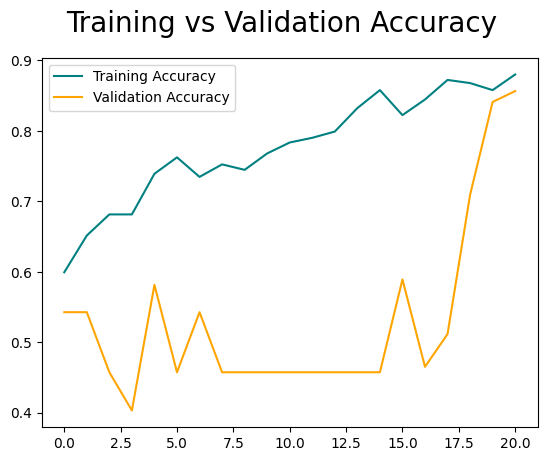

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('Training vs Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

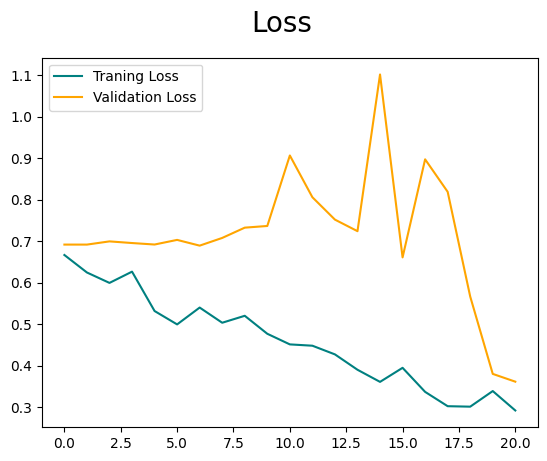

In [22]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Traning Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [24]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [25]:
steps = len(test_datas)
for _ in range(steps):
    X, y = next(test_datas)
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [26]:
print(f'Precision:{pre.result().numpy()}, Recall: {re.result().numpy()}, Binary Accuracy:{acc.result().numpy()}')

Precision:0.8153846263885498, Recall: 0.8153846263885498, Binary Accuracy:0.8153846263885498


In [28]:
test_loss, test_accuracy = model.evaluate(test_datas)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - accuracy: 0.8940 - loss: 0.2337


In [29]:
model.save(os.path.join('shufflenet_models/forharddataset', 'accur08882valacc08566.h5'))

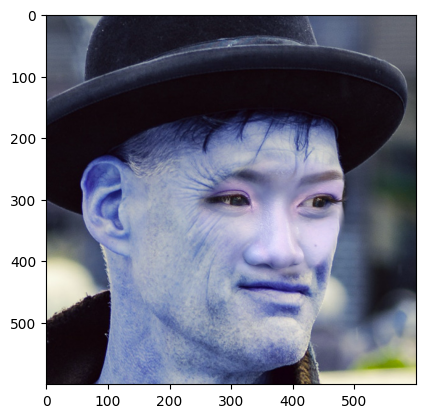

In [50]:
import cv2
import numpy as np
img = cv2.imread('datasets/realfakedataset_EASY/fulldatas/fake/65.jpg')
plt.imshow(img)
plt.show()

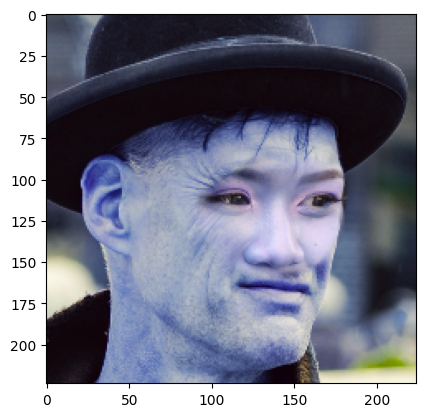

array([[[[ 76.50797 ,  81.50797 ,  96.50797 ],
         [ 77.952484,  82.952484,  97.952484],
         [ 76.06314 ,  81.06314 ,  96.06314 ],
         ...,
         [ 96.65237 , 100.65237 , 111.65237 ],
         [ 96.672844, 100.672844, 111.672844],
         [ 96.160706, 100.160706, 111.160706]],

        [[ 75.43463 ,  80.43463 ,  95.43463 ],
         [ 73.98151 ,  78.98151 ,  93.98151 ],
         [ 75.61416 ,  80.61416 ,  95.61416 ],
         ...,
         [ 98.19641 , 102.19641 , 113.19641 ],
         [ 97.2497  , 101.2497  , 112.2497  ],
         [ 97.15497 , 101.15497 , 112.15497 ]],

        [[ 73.478   ,  80.478   ,  95.478   ],
         [ 72.678566,  79.678566,  94.678566],
         [ 71.56856 ,  78.56856 ,  93.56856 ],
         ...,
         [ 98.19643 , 102.19643 , 113.19643 ],
         [ 99.19103 , 103.19103 , 114.19103 ],
         [ 95.71016 ,  99.71016 , 110.71016 ]],

        ...,

        [[ 19.035696,  12.232108,  17.232107],
         [ 24.219732,  17.416143,  22.416143]

In [51]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()
np.expand_dims(resize, 0)

In [52]:
np.expand_dims(resize, 0).shape
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [53]:
yhat

array([[0.8810991 , 0.11890086]], dtype=float32)

In [54]:
print(f'Fake Face Probability: {yhat[0,0]}')
print(f'Real Face Probability: {yhat[0,1]}')

Fake Face Probability: 0.8810991048812866
Real Face Probability: 0.1189008578658104


In [58]:
num_batches = len(test_datas)
batch_size = test_datas.batch_size
total_samples = test_datas.samples

# Calculate the number of steps (batches)
steps = total_samples // batch_size
if total_samples % batch_size != 0:
    steps += 1  # If there are remaining samples, add one more step

# Initialize lists to hold true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for step in range(steps):
    X, y = next(test_datas)
    yhat = model.predict(X)
    y_true.extend(np.argmax(y, axis=1))  # Assuming y is one-hot encoded
    y_pred.extend(np.argmax(yhat, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average='binary') 

recall = recall_score(y_true, y_pred, average='binary')  

f1 = f1_score(y_true, y_pred, average='binary')  

cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.8615384615384616
Precision: 0.9183673469387755
Recall: 0.7627118644067796
F1 Score: 0.8333333333333334
Confusion Matrix:
[[67  4]
 [14 45]]


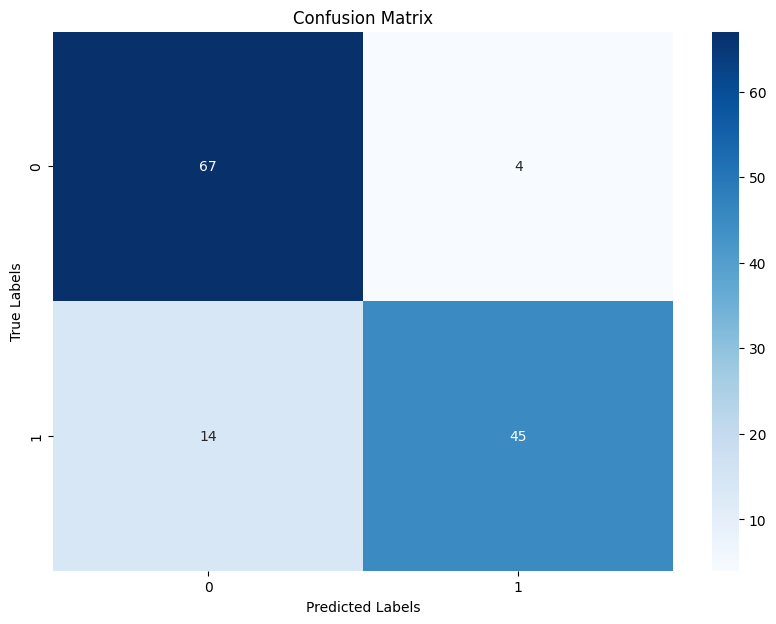

In [64]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()